In [37]:
import tkinter as tk
from tkinter import filedialog, messagebox
import random
import matplotlib.pyplot as plt

# -------------------------- Process Generator -------------------------- #
def generate_processes(input_file, output_file):
    with open(input_file, 'r') as f:
        lines = f.read().splitlines()

    num_processes = int(lines[0])  # Total number of processes
    arrival_mean, arrival_std = map(float, lines[1].split())  # Arrival time stats
    burst_mean, burst_std = map(float, lines[2].split())  # Burst time stats
    priority_lambda = float(lines[3])  # Lambda for priority

    processes = []
    for i in range(num_processes):
        # Generate process attributes randomly based on input stats
        arrival_time = max(0, int(random.gauss(arrival_mean, arrival_std)))
        burst_time = max(1, int(random.gauss(burst_mean, burst_std)))
        priority = max(1, int(random.expovariate(priority_lambda)))
        processes.append((f"P{i+1}", arrival_time, burst_time, priority))

    # Write generated processes to output file
    with open(output_file, 'w') as f:
        f.write(f"{num_processes}\n")
        f.write("ProcessID ArrivalTime BurstTime Priority\n")
        for p in processes:
            f.write(f"{p[0]} {p[1]} {p[2]} {p[3]}\n")

    return processes  # Return list for use

In [38]:
# -------------------------- Scheduling Algorithms -------------------------- #
def fcfs(processes):
    # First Come First Serve (sort by arrival time)
    processes.sort(key=lambda x: x[1])
    time = 0
    result = []
    execution_log = []
    for p in processes:
        start = max(time, p[1])
        end = start + p[2]
        waiting = start - p[1]
        turnaround = waiting + p[2]
        result.append((p[0], waiting, turnaround))
        execution_log.append((p[0], start, end))
        time = end
    return result, execution_log

In [39]:
def non_preemptive_priority(processes):
    # Sort first by arrival, then by priority (higher value = higher priority)
    processes.sort(key=lambda x: (x[1], -x[3]))
    time = 0
    result = []
    ready = []
    execution_log = []
    i = 0
    n = len(processes)

    while len(result) < n:
        while i < n and processes[i][1] <= time:
            ready.append(processes[i])
            i += 1
        if not ready:
            time += 1
            continue
        # Sort ready queue by highest priority
        ready.sort(key=lambda x: -x[3])
        p = ready.pop(0)
        start = max(time, p[1])
        end = start + p[2]
        waiting = start - p[1]
        turnaround = waiting + p[2]
        result.append((p[0], waiting, turnaround))
        execution_log.append((p[0], start, end))
        time = end
    return result, execution_log

In [40]:
def round_robin(processes, quantum=4):
    # Round Robin scheduling with fixed time quantum
    from collections import deque
    queue = deque()
    processes.sort(key=lambda x: x[1])
    time = 0
    i = 0
    n = len(processes)

    # Initialize tracking variables
    remaining = {p[0]: p[2] for p in processes}
    start_times = {}
    completion = {}
    wait = {p[0]: 0 for p in processes}
    last_seen = {p[0]: p[1] for p in processes}
    execution_log = []

    # Start with first process in queue
    queue.append(processes[0])
    i = 1

    while queue:
        current = queue.popleft()
        pid, arrival, burst, priority = current
        if remaining[pid] == burst:
            start_times[pid] = max(time, arrival)

        # Execute for quantum or remaining time
        exec_time = min(quantum, remaining[pid])
        start = max(time, arrival)
        end = start + exec_time
        time = end
        remaining[pid] -= exec_time

        execution_log.append((pid, start, end))

        # Add new arrivals to queue
        while i < n and processes[i][1] <= time:
            queue.append(processes[i])
            i += 1

        # If not finished, re-add to queue
        if remaining[pid] > 0:
            queue.append((pid, time, burst, priority))
        else:
            completion[pid] = time

        wait[pid] += time - last_seen[pid] - exec_time
        last_seen[pid] = time

    result = []
    for p in processes:
        turnaround = completion[p[0]] - p[1]
        result.append((p[0], wait[p[0]], turnaround))
    return result, execution_log

In [41]:
def srtf(processes):
    # Shortest Remaining Time First (preemptive)
    import heapq  # Use a min-heap to always pick the process with the shortest remaining time

    n = len(processes)
    time = 0
    completed = 0
    heap = []
    result = []
    i = 0

    # Store remaining burst time for each process by its ID
    remaining = {p[0]: p[2] for p in processes}
    start = {}
    finish = {}
    execution_log = []

    # Sort processes by arrival time
    processes.sort(key=lambda x: x[1])

    current_pid = None
    current_start = None

    while completed < n:
        # Add all processes that have arrived so far to the heap
        while i < n and processes[i][1] <= time:
            pid, arrival, burst, priority = processes[i]
            heapq.heappush(heap, (remaining[pid], arrival, pid, burst))
            i += 1

        # If no process, continue
        if not heap:
            time += 1
            continue

        # Pick the process with the shortest remaining time
        rem, arrival, pid, burst = heapq.heappop(heap)

        # Start a new execution block if context switch happens
        if current_pid != pid:
            if current_pid is not None and current_start is not None:
                execution_log.append((current_pid, current_start, time))
            current_pid = pid
            current_start = time

        # Execute for 1 unit time
        remaining[pid] -= 1
        time += 1

        # If not finished, return to queue with updated time
        if remaining[pid] > 0:
            heapq.heappush(heap, (remaining[pid], arrival, pid, burst))
        else:
            # If finished, record completion time
            finish[pid] = time
            completed += 1
            execution_log.append((pid, current_start, time))
            current_pid = None
            current_start = None

    for p in processes:  # Record completion time
        pid = p[0]
        turnaround = finish[pid] - p[1]
        waiting = turnaround - p[2]
        result.append((pid, waiting, turnaround))

    return result, execution_log

In [42]:
# -------------------------- Metrics & Visualization -------------------------- #
def calculate_averages(results):
    # Calculate average waiting and turnaround time
    waiting = [r[1] for r in results]
    turnaround = [r[2] for r in results]
    return sum(waiting)/len(waiting), sum(turnaround)/len(turnaround)

def plot_results(results_dict):
    # Create bar chart comparing scheduling algorithms
    algos = list(results_dict.keys())
    waiting = []
    turnaround = []
    for algo in algos:
        avg_w, avg_t = calculate_averages(results_dict[algo][0])
        waiting.append(avg_w)
        turnaround.append(avg_t)

    x = range(len(algos))
    plt.bar(x, waiting, width=0.4, label='Average Waiting Time', align='center')
    plt.bar([i + 0.4 for i in x], turnaround, width=0.4, label='Average Turnaround Time', align='center')
    plt.xticks([i + 0.2 for i in x], algos)
    plt.legend()
    plt.title('Scheduling Algorithm Comparison')
    plt.ylabel('Time Units')
    plt.xlabel('Algorithm')
    plt.tight_layout()
    plt.show()

def generate_gantt_chart(execution_log, title):
    fig, ax = plt.subplots(figsize=(18, 4))  # Make the chart wider

    y_pos = 10
    colors = {}

    # Assign unique colors to each process
    for pid, _, _ in execution_log:
        if pid not in colors:
            colors[pid] = f"C{len(colors)}"

    for pid, start, end in execution_log:
        ax.broken_barh([(start, end - start)], (y_pos, 9), facecolors=colors[pid])
        ax.text(start + (end - start) / 2, y_pos + 4.5, pid, ha='center', va='center', color='white', fontsize=8)
        # Vertical lines and time labels
        ax.axvline(x=start, color='black', linestyle='--', linewidth=0.5)
        ax.axvline(x=end, color='black', linestyle='--', linewidth=0.5)
        ax.text(start, y_pos + 10, str(start), ha='center', va='bottom', fontsize=6)
        ax.text(end, y_pos + 10, str(end), ha='center', va='bottom', fontsize=6)

    ax.set_ylim(5, 25)
    ax.set_xlim(0, max(end for _, _, end in execution_log) + 2)
    ax.set_xlabel('Time Units')
    ax.set_yticks([])
    ax.set_title(f"{title} - Gantt Chart")
    plt.tight_layout()
    plt.show()

FCFS => Avg Waiting: 17.14, Avg Turnaround: 24.14


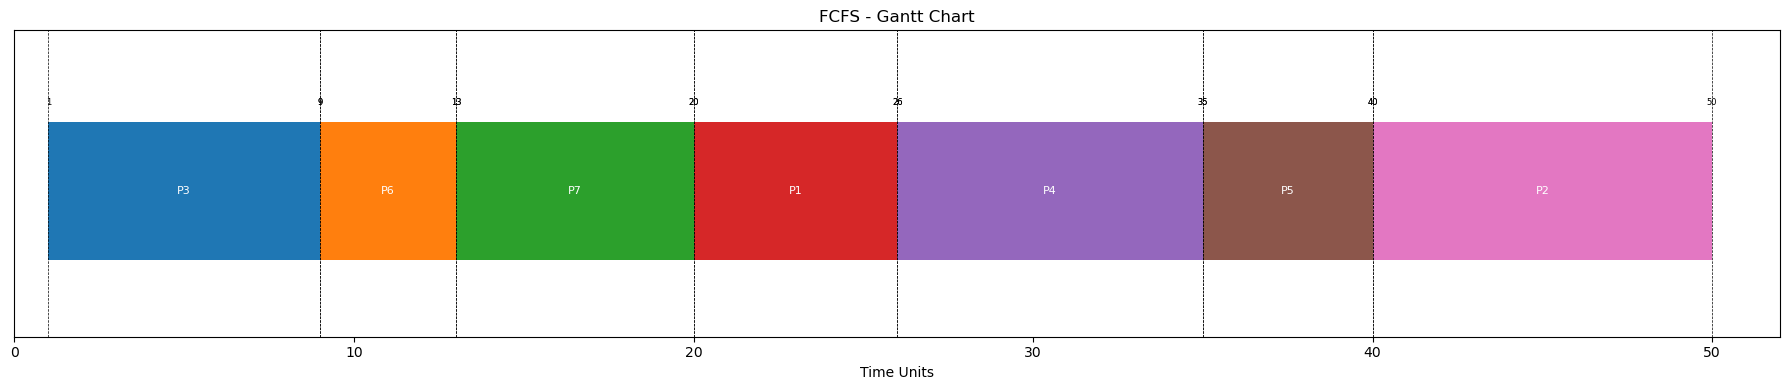

Priority => Avg Waiting: 17.14, Avg Turnaround: 24.14


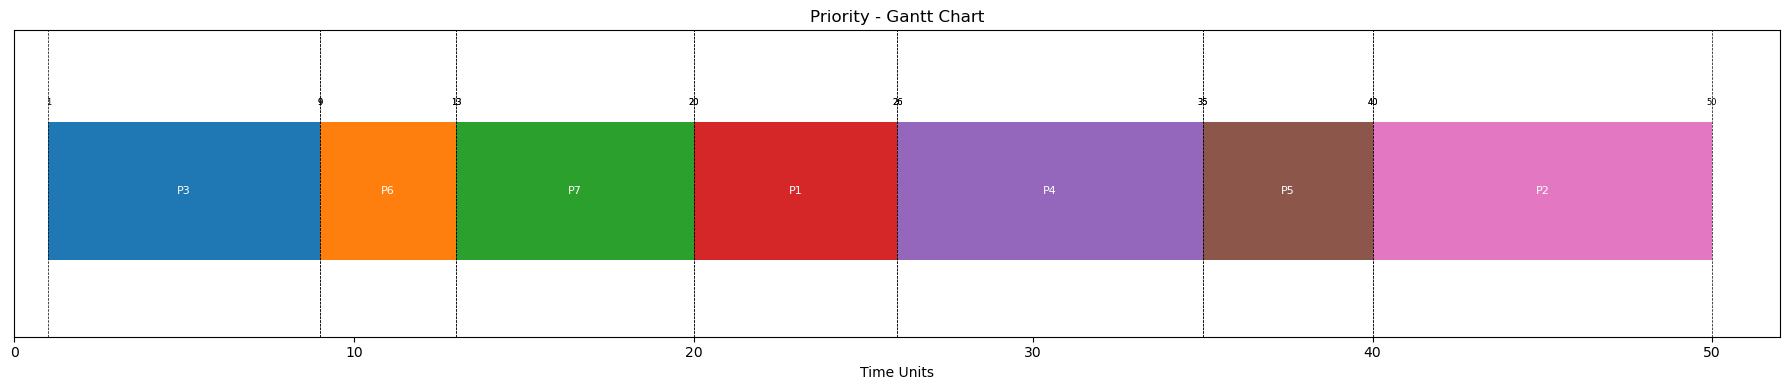

Round Robin => Avg Waiting: 26.29, Avg Turnaround: 33.29


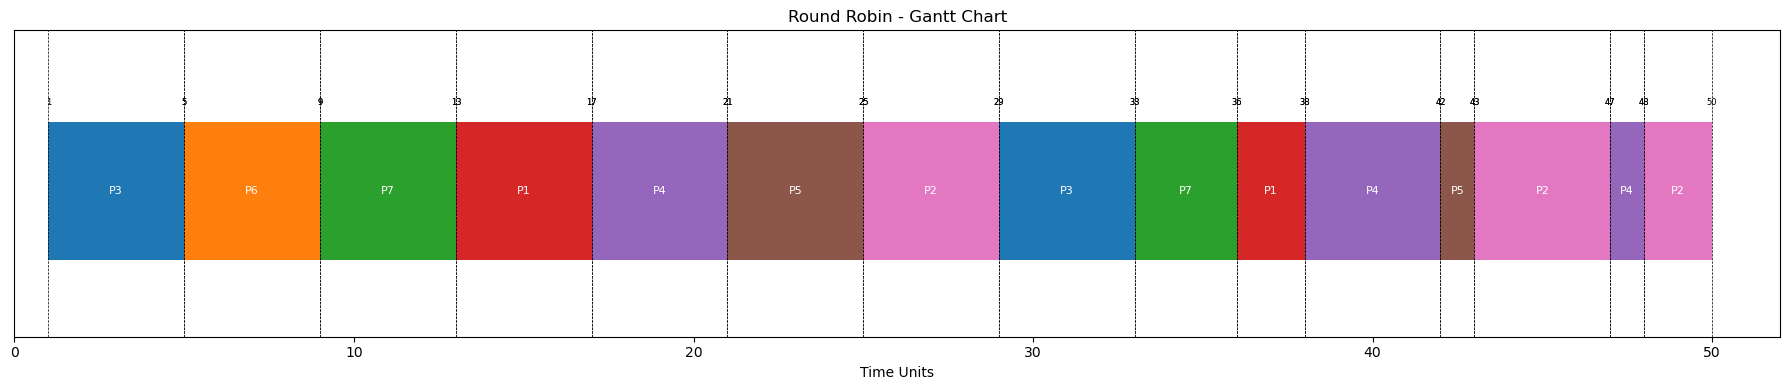

SRTF => Avg Waiting: 15.57, Avg Turnaround: 22.57


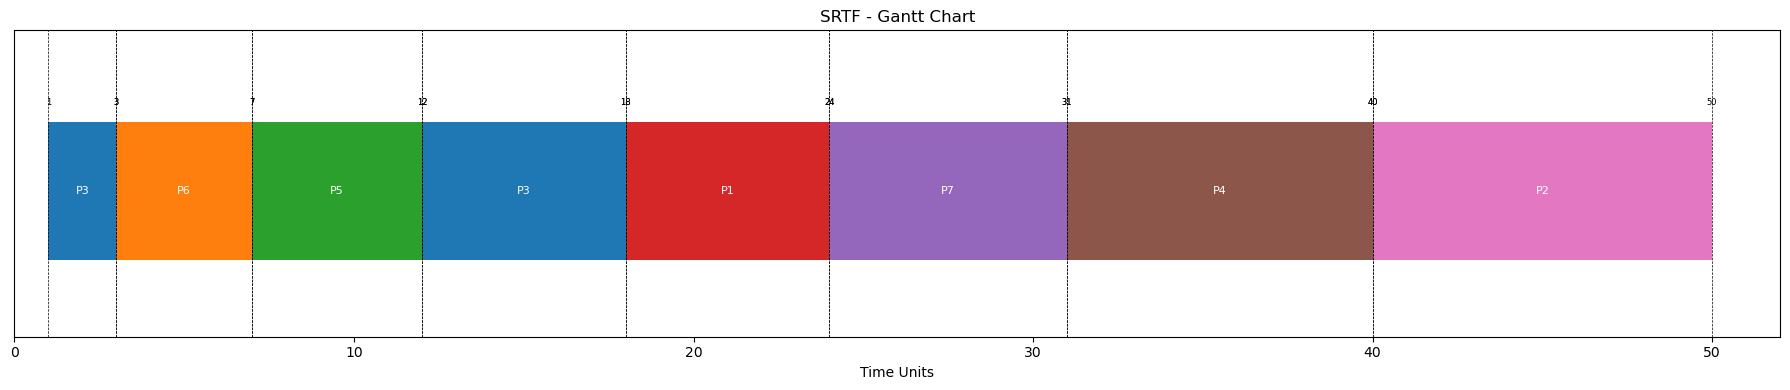

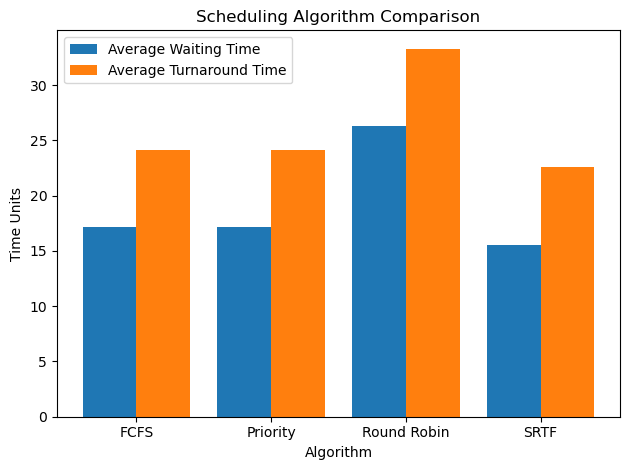

In [43]:
# -------------------------- GUI Application -------------------------- #
class SchedulerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("OS Scheduler")  # Window title

        self.input_file = ""
        self.output_file = "generated_processes.txt"

        # Create buttons for user interaction
        tk.Button(root, text="Select Input File", command=self.load_input).pack(pady=5)
        tk.Button(root, text="Generate Processes", command=self.generate).pack(pady=5)
        tk.Button(root, text="Run Scheduler", command=self.schedule).pack(pady=5)

    def load_input(self):
        # Load text input file using file dialog
        self.input_file = filedialog.askopenfilename(title="Select input file")
        messagebox.showinfo("File Loaded", f"Input file loaded: {self.input_file}")

    def generate(self):
        # Generate random processes from input stats
        if not self.input_file:
            messagebox.showerror("Error", "Please load an input file first.")
            return
        self.processes = generate_processes(self.input_file, self.output_file)
        messagebox.showinfo("Success", f"Processes generated and saved to {self.output_file}")

    def schedule(self):
        # Load generated processes from file
        with open(self.output_file, 'r') as f:
            lines = f.readlines()[2:]
            self.processes = [
                (line.split()[0], int(line.split()[1]), int(line.split()[2]), int(line.split()[3]))
                for line in lines
            ]

        # Run all scheduling algorithms and display results
        results = {
            "FCFS": fcfs(self.processes.copy()),
            "Priority": non_preemptive_priority(self.processes.copy()),
            "Round Robin": round_robin(self.processes.copy()),
            "SRTF": srtf(self.processes.copy()),
        }

        for algo, (res, log) in results.items():
            avg_wait, avg_turn = calculate_averages(res)
            print(f"{algo} => Avg Waiting: {avg_wait:.2f}, Avg Turnaround: {avg_turn:.2f}")
            generate_gantt_chart(log, algo)  # Show Gantt chart per algorithm

        plot_results(results)  # Show comparison chart

# -------------------------- Main -------------------------- #
if __name__ == '__main__':
    root = tk.Tk()
    app = SchedulerApp(root)  # Launch the app
    root.mainloop()  # Start the GUI event loop